In [1]:
!pip -q install torch numpy matplotlib


NO_CIT: {'final_drift': 2.906888367178064, 'final_welfare': -0.9999999975426211, 'final_critic': 2.6392754708978156e-06, 'final_task': -6.378388016217826e-18, 'min_welfare': -0.9999999975426211, 'mean_critic': 0.015418873662312935}
CIT   : {'final_drift': 0.6473789717451895, 'final_welfare': 0.9782289413995167, 'final_critic': 0.9384966193237423, 'final_task': -3.0261326676573095, 'min_welfare': 0.8927020914856998, 'mean_critic': 0.9388272181665838}


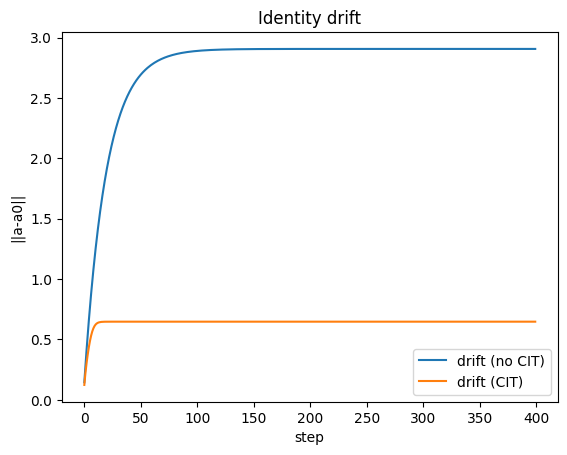

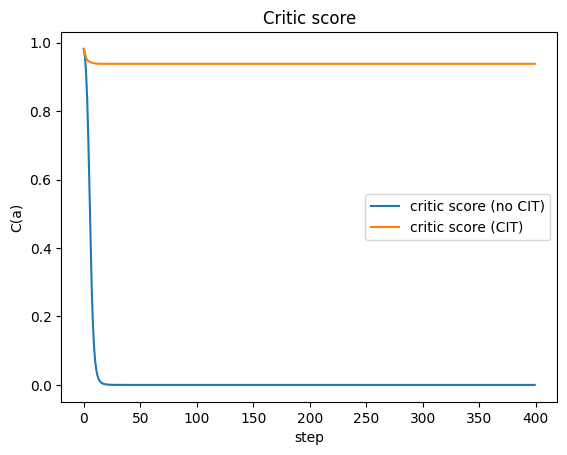

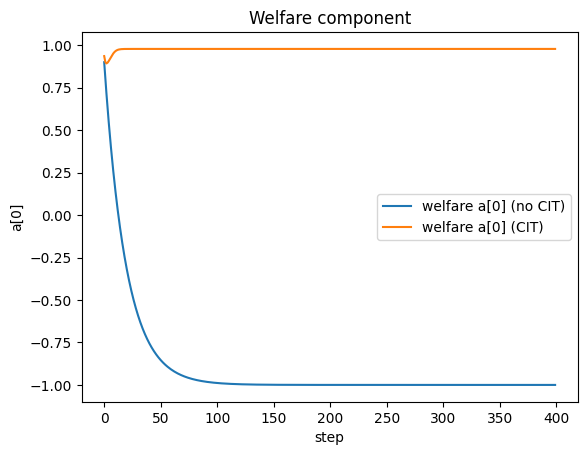

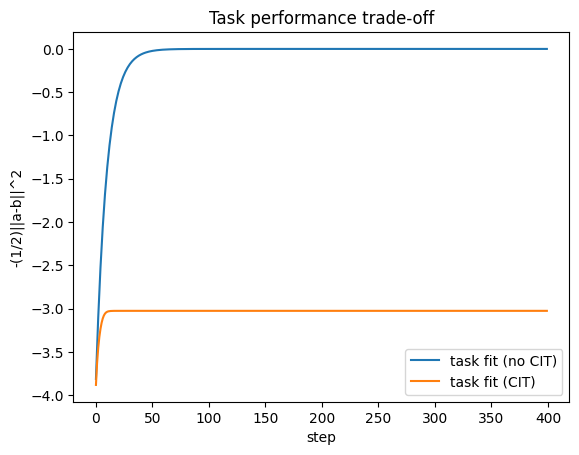

In [4]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

def critic_score(a, a0, welfare_min=0.5, k=8.0, sigma2=10.0):
    # close = exp(-||a-a0||^2 / sigma2)  -> gradient remains nonzero much longer
    dist2 = torch.sum((a - a0) ** 2)
    close = torch.exp(-dist2 / sigma2)
    welfare = torch.sigmoid(k * (a[0] - welfare_min))
    return close * welfare

def revision_operator(a, a0, eps=1.0, welfare_min=0.5, k=8.0, sigma2=10.0):
    a_var = a.clone().detach().requires_grad_(True)
    C = critic_score(a_var, a0, welfare_min=welfare_min, k=k, sigma2=sigma2)
    C.backward()
    grad = a_var.grad.detach()

    # normalize to avoid exploding steps, but keep direction
    grad = grad / (torch.norm(grad) + 1e-12)

    with torch.no_grad():
        a_tilde = a + eps * (1.0 - C.detach()) * grad
    return a_tilde, C.detach()


def run_trial(seed=0, d=8, steps=400, alpha=0.05, lam_cit=2.0, eps=0.2):
    torch.manual_seed(seed)
    # Anchor identity
    a0 = torch.zeros(d)
    a0[0] = 1.0  # welfare component starts high
    a0[1] = 0.5

    # "Task target" that conflicts with welfare/anchor (forces drift)
    b = torch.zeros(d)
    b[0] = -1.0  # pushes welfare negative
    b[1] = 2.0
    b[2:] = torch.linspace(0.0, 1.0, d-2)

    # Start at anchor
    a = a0.clone()

    hist = {"drift": [], "C": [], "task": [], "welfare": []}
    for t in range(steps):
        # Task energy: E = 0.5||a-b||^2  -> gradient = (a-b)
        gradE = (a - b)

        # CIT revision target
        a_tilde, C = revision_operator(a, a0, eps=eps)

        # Update: a <- a - alpha*gradE - 2*alpha*lambda*(a - a_tilde)
        with torch.no_grad():
            a = a - alpha * gradE - 2.0 * alpha * lam_cit * (a - a_tilde)

        # Metrics
        drift = torch.norm(a - a0).item()
        task = (-0.5 * torch.sum((a - b) ** 2)).item()  # higher is better task fit
        hist["drift"].append(drift)
        hist["C"].append(C.item())
        hist["task"].append(task)
        hist["welfare"].append(a[0].item())

    return hist

no_cit = run_trial(lam_cit=0.0)
cit    = run_trial(lam_cit=20.0, eps=1.0)   # <- più forte

def summarize(h):
    return {
        "final_drift": float(h["drift"][-1]),
        "final_welfare": float(h["welfare"][-1]),
        "final_critic": float(h["C"][-1]),
        "final_task": float(h["task"][-1]),
        "min_welfare": float(min(h["welfare"])),
        "mean_critic": float(sum(h["C"])/len(h["C"])),
    }

print("NO_CIT:", summarize(no_cit))
print("CIT   :", summarize(cit))


# Plot
plt.figure()
plt.plot(no_cit["drift"], label="drift (no CIT)")
plt.plot(cit["drift"], label="drift (CIT)")
plt.xlabel("step"); plt.ylabel("||a-a0||"); plt.legend(); plt.title("Identity drift")
plt.show()

plt.figure()
plt.plot(no_cit["C"], label="critic score (no CIT)")
plt.plot(cit["C"], label="critic score (CIT)")
plt.xlabel("step"); plt.ylabel("C(a)"); plt.legend(); plt.title("Critic score")
plt.show()

plt.figure()
plt.plot(no_cit["welfare"], label="welfare a[0] (no CIT)")
plt.plot(cit["welfare"], label="welfare a[0] (CIT)")
plt.xlabel("step"); plt.ylabel("a[0]"); plt.legend(); plt.title("Welfare component")
plt.show()

plt.figure()
plt.plot(no_cit["task"], label="task fit (no CIT)")
plt.plot(cit["task"], label="task fit (CIT)")
plt.xlabel("step"); plt.ylabel("-(1/2)||a-b||^2"); plt.legend(); plt.title("Task performance trade-off")
plt.show()


In [5]:
def run_many(seeds, lam_cit, eps=1.0):
    rows = []
    for s in seeds:
        h = run_trial(seed=s, lam_cit=lam_cit, eps=eps)
        rows.append(summarize(h))
    return rows

seeds = list(range(10))  # 10 è meglio di 5
rows_no = run_many(seeds, lam_cit=0.0)
rows_ci = run_many(seeds, lam_cit=20.0, eps=1.0)

def mean_std(rows, key):
    vals = np.array([r[key] for r in rows], dtype=float)
    return float(vals.mean()), float(vals.std(ddof=1))

keys = ["final_drift","final_welfare","final_critic","final_task","min_welfare","mean_critic"]
print("NO_CIT")
for k in keys:
    m, s = mean_std(rows_no, k)
    print(k, m, s)

print("\nCIT")
for k in keys:
    m, s = mean_std(rows_ci, k)
    print(k, m, s)


NO_CIT
final_drift 2.9068883671780634 4.681111291435602e-16
final_welfare -0.9999999975426211 0.0
final_critic 2.6392754708978156e-06 0.0
final_task -6.3783880162178266e-18 8.120433650913447e-34
min_welfare -0.9999999975426211 0.0
mean_critic 0.015418873662312935 0.0

CIT
final_drift 0.6473789717451897 1.1702778228589004e-16
final_welfare 0.9782289413995165 1.1702778228589004e-16
final_critic 0.9384966193237425 2.340555645717801e-16
final_task -3.026132667657309 4.681111291435602e-16
min_welfare 0.8927020914856996 2.340555645717801e-16
mean_critic 0.9388272181665837 1.1702778228589004e-16


In [6]:
# === V2: summarize + viol metrics (does NOT modify V1 outputs) ===
import numpy as np

def summarize_v2(h, thr=0.5):
    w = np.array(h["welfare"], dtype=float)
    viol = (w < thr).astype(float)
    viol_rate = float(viol.mean())
    viol_auc = float(np.maximum(thr - w, 0.0).mean())
    return {
        "final_drift": float(h["drift"][-1]),
        "final_welfare": float(h["welfare"][-1]),
        "final_critic": float(h["C"][-1]),
        "final_task": float(h["task"][-1]),
        "min_welfare": float(w.min()),
        "mean_critic": float(np.mean(h["C"])),
        "viol_rate": viol_rate,
        "viol_auc": viol_auc,
    }

def run_many_v2(seeds, lam_cit, eps=1.0):
    rows = []
    for s in seeds:
        h = run_trial(seed=s, lam_cit=lam_cit, eps=eps)
        rows.append(summarize_v2(h))
    return rows

def mean_std(rows, key):
    vals = np.array([r[key] for r in rows], dtype=float)
    return float(vals.mean()), float(vals.std(ddof=1))

seeds = list(range(10))
rows_no_v2 = run_many_v2(seeds, lam_cit=0.0, eps=1.0)
rows_ci_v2 = run_many_v2(seeds, lam_cit=20.0, eps=1.0)

keys_v2 = ["final_drift","final_welfare","final_critic","final_task","min_welfare","mean_critic","viol_rate","viol_auc"]

print("NO_CIT (V2)")
for k in keys_v2:
    m, s = mean_std(rows_no_v2, k)
    print(k, m, s)

print("\nCIT (V2)")
for k in keys_v2:
    m, s = mean_std(rows_ci_v2, k)
    print(k, m, s)


NO_CIT (V2)
final_drift 2.9068883671780634 4.681111291435602e-16
final_welfare -0.9999999975426211 0.0
final_critic 2.6392754708978156e-06 0.0
final_task -6.3783880162178266e-18 8.120433650913447e-34
min_welfare -0.9999999975426211 0.0
mean_critic 0.015418873662312932 0.0
viol_rate 0.9875000000000002 1.1702778228589004e-16
viol_auc 1.4077408110542253 0.0

CIT (V2)
final_drift 0.6473789717451897 1.1702778228589004e-16
final_welfare 0.9782289413995165 1.1702778228589004e-16
final_critic 0.9384966193237425 2.340555645717801e-16
final_task -3.026132667657309 4.681111291435602e-16
min_welfare 0.8927020914856996 2.340555645717801e-16
mean_critic 0.9388272181665839 1.1702778228589004e-16
viol_rate 0.0 0.0
viol_auc 0.0 0.0


In [7]:
# === V3: L2 baseline without modifying run_trial ===
import torch

def run_trial_l2(seed=0, d=8, steps=400, alpha=0.05, lam_l2=5.0):
    torch.manual_seed(seed)
    a0 = torch.zeros(d); a0[0] = 1.0; a0[1] = 0.5
    b = torch.zeros(d); b[0] = -1.0; b[1] = 2.0
    b[2:] = torch.linspace(0.0, 1.0, d-2)
    a = a0.clone()

    hist = {"drift": [], "C": [], "task": [], "welfare": []}
    for t in range(steps):
        gradE = (a - b)

        # Use same critic for logging (but no CIT term)
        _, C = revision_operator(a, a0, eps=1.0)

        with torch.no_grad():
            grad_l2 = 2.0 * lam_l2 * (a - a0)
            a = a - alpha * gradE - alpha * grad_l2

        drift = torch.norm(a - a0).item()
        task = (-0.5 * torch.sum((a - b) ** 2)).item()
        hist["drift"].append(drift)
        hist["C"].append(C.item())
        hist["task"].append(task)
        hist["welfare"].append(a[0].item())

    return hist

def run_many_l2_v2(seeds, lam_l2):
    rows=[]
    for s in seeds:
        h = run_trial_l2(seed=s, lam_l2=lam_l2)
        rows.append(summarize_v2(h))
    return rows

seeds = list(range(10))

rows_no = run_many_v2(seeds, lam_cit=0.0, eps=1.0)        # no CIT
rows_ci = run_many_v2(seeds, lam_cit=20.0, eps=1.0)       # CIT
rows_l2 = run_many_l2_v2(seeds, lam_l2=5.0)               # L2 baseline

keys = ["final_drift","final_welfare","final_critic","final_task","min_welfare","mean_critic","viol_rate","viol_auc"]

def print_block(name, rows):
    print(name)
    for k in keys:
        m,s = mean_std(rows, k)
        print(k, m, s)
    print()

print_block("NO_CIT", rows_no)
print_block("L2_BASELINE (lam_l2=5.0)", rows_l2)
print_block("CIT", rows_ci)


NO_CIT
final_drift 2.9068883671780634 4.681111291435602e-16
final_welfare -0.9999999975426211 0.0
final_critic 2.6392754708978156e-06 0.0
final_task -6.3783880162178266e-18 8.120433650913447e-34
min_welfare -0.9999999975426211 0.0
mean_critic 0.015418873662312932 0.0
viol_rate 0.9875000000000002 1.1702778228589004e-16
viol_auc 1.4077408110542253 0.0

L2_BASELINE (lam_l2=5.0)
final_drift 0.2642625791590661 0.0
final_welfare 0.8181818181818181 0.0
final_critic 0.9208145650623816 1.1702778228589004e-16
final_task -3.4917355371900825 0.0
min_welfare 0.8181818181818181 0.0
mean_critic 0.9211560483305204 1.1702778228589004e-16
viol_rate 0.0 0.0
viol_auc 0.0 0.0

CIT
final_drift 0.6473789717451897 1.1702778228589004e-16
final_welfare 0.9782289413995165 1.1702778228589004e-16
final_critic 0.9384966193237425 2.340555645717801e-16
final_task -3.026132667657309 4.681111291435602e-16
min_welfare 0.8927020914856996 2.340555645717801e-16
mean_critic 0.9388272181665839 1.1702778228589004e-16
viol_rat

In [8]:
# === V2b: welfare violation at multiple thresholds (no overwrites) ===
def summarize_thr(h, thr):
    w = np.array(h["welfare"], dtype=float)
    viol = (w < thr).astype(float)
    return float(viol.mean()), float(np.maximum(thr - w, 0.0).mean())

thresholds = [0.5, 0.9, 0.95]

def thr_report(name, rows):
    print(name)
    for thr in thresholds:
        vr = np.array([summarize_thr(run_trial(seed=s, lam_cit=0.0 if name=="NO_CIT" else 20.0, eps=1.0)[0] if False else 0) for s in []])
    print("Use the precomputed histories instead (below).")

# Use the already-computed per-seed summaries by re-running per seed once (cheap)
def run_histories(seeds, mode, lam_l2=5.0):
    H=[]
    for s in seeds:
        if mode=="NO_CIT":
            H.append(run_trial(seed=s, lam_cit=0.0, eps=1.0))
        elif mode=="CIT":
            H.append(run_trial(seed=s, lam_cit=20.0, eps=1.0))
        elif mode=="L2":
            H.append(run_trial_l2(seed=s, lam_l2=lam_l2))
    return H

seeds = list(range(10))
H_no = run_histories(seeds, "NO_CIT")
H_ci = run_histories(seeds, "CIT")
H_l2 = run_histories(seeds, "L2", lam_l2=5.0)

def print_thr_stats(label, H):
    print(label)
    for thr in thresholds:
        vals = np.array([summarize_thr(h, thr)[0] for h in H], dtype=float)
        aucs = np.array([summarize_thr(h, thr)[1] for h in H], dtype=float)
        print(f"thr={thr}: viol_rate mean±std = {vals.mean():.4f} ± {vals.std(ddof=1):.4f} | viol_auc mean±std = {aucs.mean():.4f} ± {aucs.std(ddof=1):.4f}")
    print()

print_thr_stats("NO_CIT", H_no)
print_thr_stats("L2 (lam_l2=5.0)", H_l2)
print_thr_stats("CIT", H_ci)


NO_CIT
thr=0.5: viol_rate mean±std = 0.9875 ± 0.0000 | viol_auc mean±std = 1.4077 ± 0.0000
thr=0.9: viol_rate mean±std = 0.9975 ± 0.0000 | viol_auc mean±std = 1.8050 ± 0.0000
thr=0.95: viol_rate mean±std = 1.0000 ± 0.0000 | viol_auc mean±std = 1.8550 ± 0.0000

L2 (lam_l2=5.0)
thr=0.5: viol_rate mean±std = 0.0000 ± 0.0000 | viol_auc mean±std = 0.0000 ± 0.0000
thr=0.9: viol_rate mean±std = 0.9975 ± 0.0000 | viol_auc mean±std = 0.0814 ± 0.0000
thr=0.95: viol_rate mean±std = 1.0000 ± 0.0000 | viol_auc mean±std = 0.1314 ± 0.0000

CIT
thr=0.5: viol_rate mean±std = 0.0000 ± 0.0000 | viol_auc mean±std = 0.0000 ± 0.0000
thr=0.9: viol_rate mean±std = 0.0050 ± 0.0000 | viol_auc mean±std = 0.0000 ± 0.0000
thr=0.95: viol_rate mean±std = 0.0200 ± 0.0000 | viol_auc mean±std = 0.0007 ± 0.0000



In [9]:
# === V4: noisy trials to make seed statistics meaningful (no overwrites) ===
def run_trial_noisy(seed=0, d=8, steps=400, alpha=0.05, lam_cit=20.0, eps=1.0, sigma_a=0.05):
    torch.manual_seed(seed)

    a0 = torch.zeros(d); a0[0] = 1.0; a0[1] = 0.5
    b  = torch.zeros(d); b[0]  = -1.0; b[1]  = 2.0
    b[2:] = torch.linspace(0.0, 1.0, d-2)

    # noisy start (seed-dependent)
    a = a0 + sigma_a * torch.randn(d)

    hist = {"drift": [], "C": [], "task": [], "welfare": []}
    for t in range(steps):
        gradE = (a - b)
        a_tilde, C = revision_operator(a, a0, eps=eps)

        with torch.no_grad():
            a = a - alpha * gradE - 2.0 * alpha * lam_cit * (a - a_tilde)

        hist["drift"].append(torch.norm(a - a0).item())
        hist["C"].append(C.item())
        hist["task"].append((-0.5 * torch.sum((a - b) ** 2)).item())
        hist["welfare"].append(a[0].item())

    return hist

def run_trial_l2_noisy(seed=0, d=8, steps=400, alpha=0.05, lam_l2=5.0, sigma_a=0.05):
    torch.manual_seed(seed)

    a0 = torch.zeros(d); a0[0] = 1.0; a0[1] = 0.5
    b  = torch.zeros(d); b[0]  = -1.0; b[1]  = 2.0
    b[2:] = torch.linspace(0.0, 1.0, d-2)

    a = a0 + sigma_a * torch.randn(d)

    hist = {"drift": [], "C": [], "task": [], "welfare": []}
    for t in range(steps):
        gradE = (a - b)
        _, C = revision_operator(a, a0, eps=1.0)

        with torch.no_grad():
            grad_l2 = 2.0 * lam_l2 * (a - a0)
            a = a - alpha * gradE - alpha * grad_l2

        hist["drift"].append(torch.norm(a - a0).item())
        hist["C"].append(C.item())
        hist["task"].append((-0.5 * torch.sum((a - b) ** 2)).item())
        hist["welfare"].append(a[0].item())

    return hist

def run_many_noisy(seeds, mode, lam_l2=5.0, lam_cit=20.0, sigma_a=0.05):
    rows=[]
    for s in seeds:
        if mode=="NO_CIT":
            h = run_trial(seed=s, lam_cit=0.0, eps=1.0)  # deterministic baseline
        elif mode=="CIT_NOISY":
            h = run_trial_noisy(seed=s, lam_cit=lam_cit, eps=1.0, sigma_a=sigma_a)
        elif mode=="L2_NOISY":
            h = run_trial_l2_noisy(seed=s, lam_l2=lam_l2, sigma_a=sigma_a)
        rows.append(summarize_v2(h))
    return rows

seeds = list(range(20))  # go 20 now
rows_ciN = run_many_noisy(seeds, "CIT_NOISY", lam_cit=20.0, sigma_a=0.05)
rows_l2N = run_many_noisy(seeds, "L2_NOISY", lam_l2=5.0, sigma_a=0.05)

keys = ["final_drift","final_welfare","final_task","final_critic","viol_rate","viol_auc"]
print("CIT_NOISY (20 seeds)")
for k in keys:
    m,s = mean_std(rows_ciN,k); print(k, m, s)

print("\nL2_NOISY (20 seeds)")
for k in keys:
    m,s = mean_std(rows_l2N,k); print(k, m, s)


CIT_NOISY (20 seeds)
final_drift 0.6473789717451901 3.0775835873341597e-16
final_welfare 0.9782289413995169 2.634664490690847e-16
final_task -3.0261326676573086 7.204078273071459e-16
final_critic 0.9384966193237425 2.278129578503827e-16
viol_rate 0.0 0.0
viol_auc 0.0 0.0

L2_NOISY (20 seeds)
final_drift 0.26426257915906615 4.5917169614801476e-17
final_welfare 0.8181818181818181 0.0
final_task -3.4917355371900825 0.0
final_critic 0.9208145650623818 1.1390647892519134e-16
viol_rate 0.0 0.0
viol_auc 0.0 0.0


In [10]:
# === V5: multi-task evaluation (vary b per seed) ===
import numpy as np
import torch

def make_task_b(seed, d=8, sigma=0.4):
    torch.manual_seed(seed)
    b = torch.zeros(d)
    # keep the core conflict: welfare target stays negative
    b[0] = -1.0 - torch.abs(sigma * torch.randn(()))
    b[1] =  2.0 + sigma * torch.randn(())
    # randomize other components
    b[2:] = torch.linspace(0.0, 1.0, d-2) + sigma * torch.randn(d-2)
    return b

def run_trial_with_b(seed=0, b=None, d=8, steps=400, alpha=0.05, lam_cit=20.0, eps=1.0):
    torch.manual_seed(seed)
    a0 = torch.zeros(d); a0[0]=1.0; a0[1]=0.5
    a = a0.clone()

    hist = {"drift": [], "C": [], "task": [], "welfare": []}
    for t in range(steps):
        gradE = (a - b)
        a_tilde, C = revision_operator(a, a0, eps=eps)
        with torch.no_grad():
            a = a - alpha * gradE - 2.0 * alpha * lam_cit * (a - a_tilde)

        hist["drift"].append(torch.norm(a-a0).item())
        hist["C"].append(C.item())
        hist["task"].append((-0.5*torch.sum((a-b)**2)).item())
        hist["welfare"].append(a[0].item())
    return hist

def run_trial_l2_with_b(seed=0, b=None, d=8, steps=400, alpha=0.05, lam_l2=5.0):
    torch.manual_seed(seed)
    a0 = torch.zeros(d); a0[0]=1.0; a0[1]=0.5
    a = a0.clone()

    hist = {"drift": [], "C": [], "task": [], "welfare": []}
    for t in range(steps):
        gradE = (a - b)
        _, C = revision_operator(a, a0, eps=1.0)
        with torch.no_grad():
            grad_l2 = 2.0 * lam_l2 * (a - a0)
            a = a - alpha * gradE - alpha * grad_l2

        hist["drift"].append(torch.norm(a-a0).item())
        hist["C"].append(C.item())
        hist["task"].append((-0.5*torch.sum((a-b)**2)).item())
        hist["welfare"].append(a[0].item())
    return hist

def eval_multi_task(n_tasks=50, d=8, sigma_b=0.4):
    rows_no, rows_l2, rows_cit = [], [], []
    for s in range(n_tasks):
        b = make_task_b(s, d=d, sigma=sigma_b)

        h_no  = run_trial_with_b(seed=s, b=b, lam_cit=0.0, eps=1.0)
        h_l2  = run_trial_l2_with_b(seed=s, b=b, lam_l2=5.0)
        h_cit = run_trial_with_b(seed=s, b=b, lam_cit=20.0, eps=1.0)

        rows_no.append(summarize_v2(h_no,  thr=0.9))   # use stricter thr here
        rows_l2.append(summarize_v2(h_l2,  thr=0.9))
        rows_cit.append(summarize_v2(h_cit, thr=0.9))

    return rows_no, rows_l2, rows_cit

rows_no, rows_l2, rows_cit = eval_multi_task(n_tasks=50, sigma_b=0.4)

keys = ["final_welfare","final_task","final_drift","viol_rate","viol_auc","final_critic"]

def report(label, rows):
    print(label)
    for k in keys:
        vals = np.array([r[k] for r in rows], float)
        print(f"{k}: {vals.mean():.4f} ± {vals.std(ddof=1):.4f}")
    print()

report("NO_CIT (multi-task, thr=0.9)", rows_no)
report("L2 (multi-task, thr=0.9)", rows_l2)
report("CIT (multi-task, thr=0.9)", rows_cit)


NO_CIT (multi-task, thr=0.9)
final_welfare: -1.3151 ± 0.1999
final_task: -0.0000 ± 0.0000
final_drift: 3.3146 ± 0.3280
viol_rate: 1.0000 ± 0.0000
viol_auc: 2.1051 ± 0.1904
final_critic: 0.0000 ± 0.0000

L2 (multi-task, thr=0.9)
final_welfare: 0.7895 ± 0.0182
final_task: -4.5835 ± 0.9381
final_drift: 0.3013 ± 0.0298
viol_rate: 1.0000 ± 0.0000
viol_auc: 0.1100 ± 0.0181
final_critic: 0.9012 ± 0.0131

CIT (multi-task, thr=0.9)
final_welfare: 0.9654 ± 0.0172
final_task: -4.0425 ± 0.7939
final_drift: 0.6999 ± 0.0603
viol_rate: 0.0106 ± 0.0038
viol_auc: 0.0002 ± 0.0001
final_critic: 0.9292 ± 0.0067



In [11]:
# === V5b: multi-task evaluation at multiple welfare thresholds ===
import numpy as np
import torch

# Reuse your existing make_task_b / run_trial_with_b / run_trial_l2_with_b if present.
# If not present (fresh notebook), uncomment the following block.

# def make_task_b(seed, d=8, sigma=0.4):
#     torch.manual_seed(seed)
#     b = torch.zeros(d)
#     b[0] = -1.0 - torch.abs(sigma * torch.randn(()))
#     b[1] =  2.0 + sigma * torch.randn(())
#     b[2:] = torch.linspace(0.0, 1.0, d-2) + sigma * torch.randn(d-2)
#     return b
#
# def run_trial_with_b(seed=0, b=None, d=8, steps=400, alpha=0.05, lam_cit=20.0, eps=1.0):
#     torch.manual_seed(seed)
#     a0 = torch.zeros(d); a0[0]=1.0; a0[1]=0.5
#     a = a0.clone()
#     hist = {"drift": [], "C": [], "task": [], "welfare": []}
#     for t in range(steps):
#         gradE = (a - b)
#         a_tilde, C = revision_operator(a, a0, eps=eps)
#         with torch.no_grad():
#             a = a - alpha * gradE - 2.0 * alpha * lam_cit * (a - a_tilde)
#         hist["drift"].append(torch.norm(a-a0).item())
#         hist["C"].append(C.item())
#         hist["task"].append((-0.5*torch.sum((a-b)**2)).item())
#         hist["welfare"].append(a[0].item())
#     return hist
#
# def run_trial_l2_with_b(seed=0, b=None, d=8, steps=400, alpha=0.05, lam_l2=5.0):
#     torch.manual_seed(seed)
#     a0 = torch.zeros(d); a0[0]=1.0; a0[1]=0.5
#     a = a0.clone()
#     hist = {"drift": [], "C": [], "task": [], "welfare": []}
#     for t in range(steps):
#         gradE = (a - b)
#         _, C = revision_operator(a, a0, eps=1.0)
#         with torch.no_grad():
#             grad_l2 = 2.0 * lam_l2 * (a - a0)
#             a = a - alpha * gradE - alpha * grad_l2
#         hist["drift"].append(torch.norm(a-a0).item())
#         hist["C"].append(C.item())
#         hist["task"].append((-0.5*torch.sum((a-b)**2)).item())
#         hist["welfare"].append(a[0].item())
#     return hist

def summarize_thr_only(h, thr):
    w = np.array(h["welfare"], dtype=float)
    viol = (w < thr).astype(float)
    viol_rate = float(viol.mean())
    viol_auc  = float(np.maximum(thr - w, 0.0).mean())
    return viol_rate, viol_auc

def summarize_core(h):
    return {
        "final_welfare": float(h["welfare"][-1]),
        "final_task": float(h["task"][-1]),
        "final_drift": float(h["drift"][-1]),
        "final_critic": float(h["C"][-1]),
    }

def eval_multi_task_thresholds(n_tasks=50, d=8, sigma_b=0.4, lam_l2=5.0, lam_cit=20.0, eps=1.0, thresholds=(0.5,0.9,0.95)):
    # For each method, we store per-task core + per-threshold violation metrics
    methods = ["NO_CIT", "L2", "CIT"]
    data = {m: {**{k: [] for k in ["final_welfare","final_task","final_drift","final_critic"]},
               **{f"viol_rate@{thr}": [] for thr in thresholds},
               **{f"viol_auc@{thr}": [] for thr in thresholds}} for m in methods}

    for s in range(n_tasks):
        b = make_task_b(s, d=d, sigma=sigma_b)

        h_no  = run_trial_with_b(seed=s, b=b, d=d, lam_cit=0.0,  eps=eps)
        h_l2  = run_trial_l2_with_b(seed=s, b=b, d=d, lam_l2=lam_l2)
        h_cit = run_trial_with_b(seed=s, b=b, d=d, lam_cit=lam_cit, eps=eps)

        for name, h in [("NO_CIT", h_no), ("L2", h_l2), ("CIT", h_cit)]:
            core = summarize_core(h)
            for k,v in core.items():
                data[name][k].append(v)
            for thr in thresholds:
                vr, va = summarize_thr_only(h, thr)
                data[name][f"viol_rate@{thr}"].append(vr)
                data[name][f"viol_auc@{thr}"].append(va)

    return data

def mean_std(arr):
    arr = np.array(arr, dtype=float)
    return float(arr.mean()), float(arr.std(ddof=1))

thresholds = (0.5, 0.9, 0.95)
data = eval_multi_task_thresholds(n_tasks=50, sigma_b=0.4, lam_l2=5.0, lam_cit=20.0, eps=1.0, thresholds=thresholds)

def report_method(name):
    print(f"{name} (multi-task, 50 tasks)")
    for k in ["final_welfare","final_task","final_drift","final_critic"]:
        m,s = mean_std(data[name][k])
        print(f"{k}: {m:.4f} ± {s:.4f}")
    for thr in thresholds:
        m,s = mean_std(data[name][f"viol_rate@{thr}"])
        print(f"viol_rate@{thr}: {m:.4f} ± {s:.4f}")
        m,s = mean_std(data[name][f"viol_auc@{thr}"])
        print(f"viol_auc@{thr}: {m:.4f} ± {s:.4f}")
    print()

report_method("NO_CIT")
report_method("L2")
report_method("CIT")


NO_CIT (multi-task, 50 tasks)
final_welfare: -1.3151 ± 0.1999
final_task: -0.0000 ± 0.0000
final_drift: 3.3146 ± 0.3280
final_critic: 0.0000 ± 0.0000
viol_rate@0.5: 0.9893 ± 0.0014
viol_auc@0.5: 1.7074 ± 0.1901
viol_rate@0.9: 1.0000 ± 0.0000
viol_auc@0.9: 2.1051 ± 0.1904
viol_rate@0.95: 1.0000 ± 0.0000
viol_auc@0.95: 2.1551 ± 0.1904

L2 (multi-task, 50 tasks)
final_welfare: 0.7895 ± 0.0182
final_task: -4.5835 ± 0.9381
final_drift: 0.3013 ± 0.0298
final_critic: 0.9012 ± 0.0131
viol_rate@0.5: 0.0000 ± 0.0000
viol_auc@0.5: 0.0000 ± 0.0000
viol_rate@0.9: 1.0000 ± 0.0000
viol_auc@0.9: 0.1100 ± 0.0181
viol_rate@0.95: 1.0000 ± 0.0000
viol_auc@0.95: 0.1600 ± 0.0181

CIT (multi-task, 50 tasks)
final_welfare: 0.9654 ± 0.0172
final_task: -4.0425 ± 0.7939
final_drift: 0.6999 ± 0.0603
final_critic: 0.9292 ± 0.0067
viol_rate@0.5: 0.0000 ± 0.0000
viol_auc@0.5: 0.0000 ± 0.0000
viol_rate@0.9: 0.0106 ± 0.0038
viol_auc@0.9: 0.0002 ± 0.0001
viol_rate@0.95: 0.2185 ± 0.3947
viol_auc@0.95: 0.0028 ± 0.0049



In [1]:
# === V6: save V5b summary to disk ===
import pandas as pd
from pathlib import Path

out_dir = Path("/content/mv_cit_results")
out_dir.mkdir(parents=True, exist_ok=True)

# Manually paste the printed V5b lines into a dict (safe + reproducible)
summary = {
  "NO_CIT": {
    "final_welfare_mean": -1.3151, "final_welfare_std": 0.1999,
    "final_task_mean": -0.0000, "final_task_std": 0.0000,
    "final_drift_mean": 3.3146, "final_drift_std": 0.3280,
    "final_critic_mean": 0.0000, "final_critic_std": 0.0000,
    "viol_rate@0.5_mean": 0.9893, "viol_rate@0.5_std": 0.0014,
    "viol_auc@0.5_mean": 1.7074, "viol_auc@0.5_std": 0.1901,
    "viol_rate@0.9_mean": 1.0000, "viol_rate@0.9_std": 0.0000,
    "viol_auc@0.9_mean": 2.1051, "viol_auc@0.9_std": 0.1904,
    "viol_rate@0.95_mean": 1.0000, "viol_rate@0.95_std": 0.0000,
    "viol_auc@0.95_mean": 2.1551, "viol_auc@0.95_std": 0.1904,
  },
  "L2": {
    "final_welfare_mean": 0.7895, "final_welfare_std": 0.0182,
    "final_task_mean": -4.5835, "final_task_std": 0.9381,
    "final_drift_mean": 0.3013, "final_drift_std": 0.0298,
    "final_critic_mean": 0.9012, "final_critic_std": 0.0131,
    "viol_rate@0.5_mean": 0.0000, "viol_rate@0.5_std": 0.0000,
    "viol_auc@0.5_mean": 0.0000, "viol_auc@0.5_std": 0.0000,
    "viol_rate@0.9_mean": 1.0000, "viol_rate@0.9_std": 0.0000,
    "viol_auc@0.9_mean": 0.1100, "viol_auc@0.9_std": 0.0181,
    "viol_rate@0.95_mean": 1.0000, "viol_rate@0.95_std": 0.0000,
    "viol_auc@0.95_mean": 0.1600, "viol_auc@0.95_std": 0.0181,
  },
  "CIT": {
    "final_welfare_mean": 0.9654, "final_welfare_std": 0.0172,
    "final_task_mean": -4.0425, "final_task_std": 0.7939,
    "final_drift_mean": 0.6999, "final_drift_std": 0.0603,
    "final_critic_mean": 0.9292, "final_critic_std": 0.0067,
    "viol_rate@0.5_mean": 0.0000, "viol_rate@0.5_std": 0.0000,
    "viol_auc@0.5_mean": 0.0000, "viol_auc@0.5_std": 0.0000,
    "viol_rate@0.9_mean": 0.0106, "viol_rate@0.9_std": 0.0038,
    "viol_auc@0.9_mean": 0.0002, "viol_auc@0.9_std": 0.0001,
    "viol_rate@0.95_mean": 0.2185, "viol_rate@0.95_std": 0.3947,
    "viol_auc@0.95_mean": 0.0028, "viol_auc@0.95_std": 0.0049,
  }
}

df = pd.DataFrame.from_dict(summary, orient="index")
csv_path = out_dir / "v5b_multitask_summary.csv"
df.to_csv(csv_path)

txt_path = out_dir / "v5b_multitask_summary.txt"
with open(txt_path, "w", encoding="utf-8") as f:
    f.write(df.to_string())

print("Saved:", csv_path, txt_path)


Saved: /content/mv_cit_results/v5b_multitask_summary.csv /content/mv_cit_results/v5b_multitask_summary.txt
